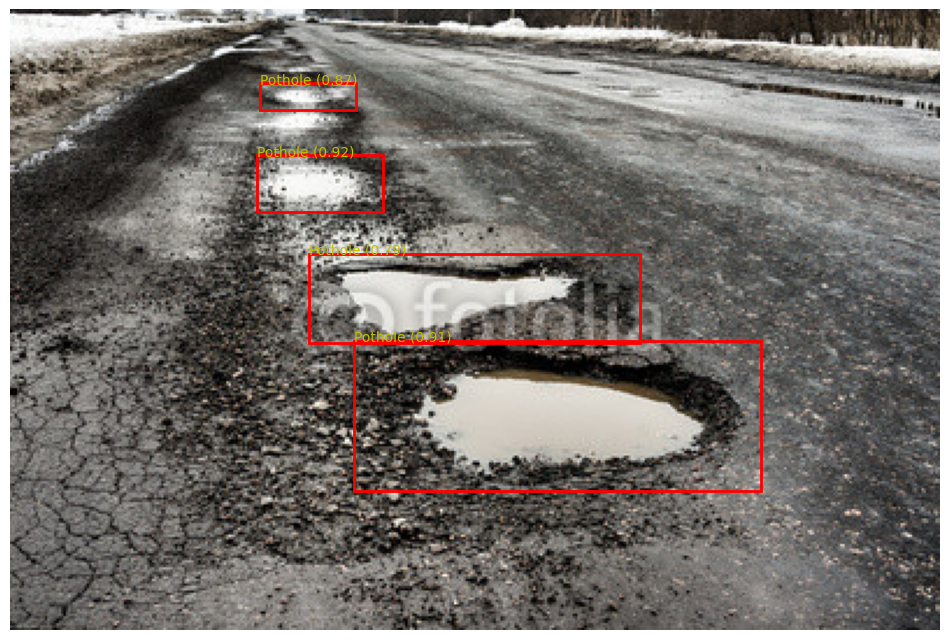

Average Confidence Score: 0.21916967630386353
Detections Above 0.75 Confidence: 4


In [2]:
import numpy as np
import torch
import torchvision
from torch.utils.data import DataLoader
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.datasets import CocoDetection
from torchvision.transforms import functional as F
import matplotlib.pyplot as plt
from PIL import Image

#Load Faster R-CNN with ResNet-50 backbone
def get_model(num_classes):
    #Load pre-trained Faster R-CNN
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    #Get the number of input fetures for the classifier
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    #Replace the pre-trained head with a new one
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)
    return model

#Initialize the model
num_classes = 2    # Background + Potholes

#Move model to GPU if available
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

#Load the trained model
model = get_model(num_classes)
model.load_state_dict(torch.load("/Users/swaksharbora/Documents/ML Assingment/models/fasterrcnn_resnet50_epoch5.pth"))
model.to(device)
model.eval()    # Set the model to evaluation mode

def prepare_image(image_path):
    image = Image.open(image_path).convert("RGB")    # Opens Image
    image_tensor = F.to_tensor(image).unsqueeze(0)    # Converts image to tensor and adds batch dimensions
    return image_tensor.to(device)

#Load the unseen image
image_path = '/Users/swaksharbora/Documents/ML Assingment/Data/test/265.jpg'
image_tensor = prepare_image(image_path)

with torch.no_grad():    # Disable gradient computation for inference
    prediction = model(image_tensor)

COCO_CLASSES = {1: "Pothole"}

# Prediction contains:
# - boxes: predicted bounding boxes
# - labels: predicted class labels
# - scores: predicted scores for each box (confidence level)

def get_class_name(class_id):
    return COCO_CLASSES.get(class_id, "Unknown")

# Draw bounding boxes with the correct class names and increase image size
def draw_boxes(image, prediction, fig_size=(10, 10)):
    boxes = prediction[0]['boxes'].cpu().numpy()   
    labels = prediction[0]['labels'].cpu().numpy()    
    scores = prediction[0]['scores'].cpu().numpy()   

    # Threshold for showing boxes
    threshold = 0.75

    # Set up the figure to control the image size
    plt.figure(figsize=fig_size) # Ajust the figure size here

    for box, label, score in zip(boxes, labels, scores):
        if score > threshold:
            x_min, y_min, x_max, y_max = box
            class_name = get_class_name(label)    # Get the class name
            plt.imshow(image)    # Display the image
            plt.gca().add_patch(plt.Rectangle((x_min, y_min), 
                                              x_max - x_min, y_max - y_min, 
                                              linewidth=2, edgecolor='r', facecolor='none'))
            plt.text(x_min, y_min, f"{class_name} ({score:.2f})", color='y')

    plt.axis('off')  
    plt.show()

# Display the image with bounding boxes and correct labels
draw_boxes(Image.open(image_path), prediction, fig_size=(12, 10))    

# Model Metrics
scores = prediction[0]['scores'].cpu().numpy()

# 1. Average confidence
avg_confidence = float(np.mean(scores))
print("Average Confidence Score:", avg_confidence)

# 2. Count detections above threshold
threshold = 0.75
num_detections = int(np.sum(scores >= threshold))
print(f"Detections Above {threshold} Confidence:", num_detections)